Adapting example from https://pyscipopt.readthedocs.io/en/latest/tutorials/model.html to fit my problem: 

In [1]:
from pyscipopt import Model, quicksum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def initialize_model():
    scip = Model()
    scip.redirectOutput() #prints to jupyter notebook
    return scip

Adjusting User Inputs:

In [ ]:
def adjust_user_inputs(a,l,w,h,prices):
    #Variable dimension info:
    n = len(a) #Total number of items on BOM
    m = n * len(l) #Upper limit of stock items we'll have to buy

    #Adjust l, w, h to be proper dimensions (using n):
    new_l = []
    for length in l:
        for i in range(n):
            new_l.append(length)
    l = new_l

    new_w = []
    for width in w:
        for i in range(n):
            new_w.append(width)
    w = new_w

    new_h = []
    for height in h:
        for i in range(n):
            new_h.append(height)
    h = new_h

    #Adjust dimensions of p / replicate each stock board n-1 times:
    p = []
    for price in prices:
        for i in range(n):
            p.append(price)

    p = np.array(p)

    return n,m,l,w,h,p

Decision Variables:

In [4]:
def create_decision_variables(scip,n,m):
    u = np.zeros((n, m), dtype=object)
    for i in range(n):
        for j in range(m):
            u[i][j] = scip.addVar(vtype='B', name=f"u_{i}_{j}")

    x = np.zeros((n,),dtype=object)
    for i in range(n):
        x[i] = scip.addVar(vtype='C',lb=0, ub=None, name=f"x_{i}")

    y = np.zeros((n,),dtype=object)
    for i in range(n):
        y[i] = scip.addVar(vtype='C',lb=0, ub=None, name=f"y_{i}")

    r = np.zeros((n,),dtype=object)
    for i in range(n):
        r[i] = scip.addVar(vtype='B', name=f"r_{i}")

    return scip,u,x,y,r

Intermediate Variables:

In [5]:
def create_intermediate_variables(scip,n,m):
    q = np.zeros((m,),dtype=object)
    for j in range(m):
        q[j] = scip.addVar(vtype='B', name=f"q_{j}")

    s = np.zeros((n, n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                s[i][k] = scip.addVar(vtype='B', name=f"s_{i}_{k}")

    t = np.zeros((n, n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                t[i][k] = scip.addVar(vtype='B', name=f"t_{i}_{k}")

    v = np.zeros((n, n), dtype=object)
    for i in range(n):
        for k in range(n):
            v[i][k] = scip.addVar(vtype='B', name=f"v_{i}_{k}")

    d = np.zeros((n, n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                d[i][k] = scip.addVar(vtype='B', name=f"d_{i}_{k}")

    f = np.zeros((n, n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                f[i][k] = scip.addVar(vtype='B', name=f"f_{i}_{k}")

    g = np.zeros((n, n), dtype=object)
    for i in range(n):
        for k in range(n):
            g[i][k] = scip.addVar(vtype='B', name=f"g_{i}_{k}")
    
    return scip,q,s,t,v,d,f,g

Constraints:

In [6]:
def write_constraints(a,b,c,l,w,h,n,m,u,x,y,r,q,s,t,v,d,f,g,scip):
    #1. All BOM items must be cut exactly once / from exactly one stock board:
    constr_1 = np.zeros((n,), dtype=object)
    for i in range(n):
        constr_1[i] = scip.addCons(quicksum(u[i][j] for j in range(m)) == 1, name=f"constr_1_{i}")
    
    #2. The thickness (smallest dimension) of each BOM item must match that of the stock item from which it's cut
    #2a.
    constr_2a = np.zeros((n,m), dtype=object)
    for i in range(n):
        for j in range(m):
            constr_2a[i][j] = scip.addCons(u[i][j] <= c[i]/h[j], name=f"constr_2a_{i}_{j}")

    #2b.
    constr_2b = np.zeros((n,m), dtype=object)
    for i in range(n):
        for j in range(m):
            constr_2b[i][j] = scip.addCons(u[i][j] <= h[j]/c[i], name=f"constr_2b_{i}_{j}")

    #3. If any BOM items are planned to be cut from stock board j, we must buy stock board j:
    constr_3 = np.zeros((m,), dtype=object)
    for j in range(m):
        constr_3[j] = scip.addCons(q[j] >= quicksum(u[i][j] for i in range(n))/n, name=f"constr_3_{j}")

    #4. BOM items cannot exceed the boundaries of the stock board from which they're cut:
    constr_4a = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4a[i][k] = scip.addCons(v[i][k] == (s[i][k] + t[i][k]), name=f"constr_4a_{i}_{k}")
            elif i == k:
                constr_4a[i][k] = scip.addCons(v[i][k] == 0, name=f"constr_4a_{i}_{k}")

    constr_4c = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4c[i][k] = scip.addCons(s[i][k] <= (y[k] + 1) / (y[i] + (1-r[i])*a[i] + r[i]*b[i]+1), name=f"constr_4c_{i}_{k}")

    constr_4d = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4d[i][k] = scip.addCons(s[i][k] >= y[k] - (y[i] + (1-r[i])*a[i] + r[i]*b[i]), name=f"constr_4d_{i}_{k}")

    #https://pyscipopt.readthedocs.io/en/stable/tutorials/expressions.html#absolute-abs
    constr_4e = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4e[i][k] = scip.addCons(s[i][k] >= 1/100 - abs(y[k] - (y[i] + (1-r[i])*a[i] + r[i]*b[i])), name=f"constr_4e_{i}_{k}")

    constr_4g = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4g[i][k] = scip.addCons(t[i][k] <= (y[i] + 1) / (y[k] + (1-r[k])*a[k] + r[k]*b[k]+1), name=f"constr_4g_{i}_{k}")

    constr_4h = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4h[i][k] = scip.addCons(t[i][k] >= y[i] - (y[k] + (1-r[k])*a[k] + r[k]*b[k]), name=f"constr_4h_{i}_{k}")

    constr_4i = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4i[i][k] = scip.addCons(t[i][k] >= 1/100 - abs(y[i] - (y[k] + (1-r[k])*a[k] + r[k]*b[k])), name=f"constr_4i_{i}_{k}")

    constr_4j = np.zeros((m,n,n), dtype=object)
    for j in range(m):
        for ii in range(n):
            constr_4j[j][ii] = scip.addCons(w[j] >=  quicksum(u[i][j]*((1-r[i])*b[i] + r[i]*a[i])*(1-v[ii][i]) for i in range(n)), name=f"constr_4j_{j}_{ii}")

    constr_4k = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4k[i][k] = scip.addCons(g[i][k] == (d[i][k] + f[i][k]), name=f"constr_4k_{i}_{k}")
            elif i == k:
                constr_4k[i][k] = scip.addCons(g[i][k] == 0, name=f"constr_4k_{i}_{k}")

    constr_4m = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4m[i][k] = scip.addCons(d[i][k] <= (x[k] + 1) / (x[i] + (1-r[i])*b[i] + r[i]*a[i]+1), name=f"constr_4m_{i}_{k}")

    constr_4n = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4n[i][k] = scip.addCons(d[i][k] >= x[k] - (x[i] + (1-r[i])*b[i] + r[i]*a[i]), name=f"constr_4n_{i}_{k}")

    constr_4o = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4o[i][k] = scip.addCons(d[i][k] >= 1/100 - abs(x[k] - (x[i] + (1-r[i])*b[i] + r[i]*a[i])), name=f"constr_4o_{i}_{k}")

    constr_4q = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4q[i][k] = scip.addCons(f[i][k] <= (x[i] + 1) / (x[k] + (1-r[k])*b[k] + r[k]*a[k]+1), name=f"constr_4q_{i}_{k}")

    constr_4r = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4r[i][k] = scip.addCons(f[i][k] >= x[i] - (x[k] + (1-r[k])*b[k] + r[k]*a[k]), name=f"constr_4r_{i}_{k}")

    constr_4s = np.zeros((n,n), dtype=object)
    for i in range(n):
        for k in range(n):
            if i != k:
                constr_4s[i][k] = scip.addCons(f[i][k] >= 1/100 - abs(x[i] - (x[k] + (1-r[k])*b[k] + r[k]*a[k])), name=f"constr_4s_{i}_{k}")

    constr_4t = np.zeros((m,n,n), dtype=object)
    for j in range(m):
        for k in range(n):
            constr_4t[j][k] = scip.addCons(l[j] >=  quicksum(u[i][j]*((1-r[i])*a[i] + r[i]*b[i])*(1-g[k][i]) for i in range(n)), name=f"constr_4t_{j}_{k}")

    #5. BOM items cannot overlap each other:
    constr_5 = np.zeros((m,n), dtype=object)
    for j in range(m):
        for k in range(n):
            constr_5[j][k] = scip.addCons(quicksum(u[i][j] * u[k][j] * (1-v[i][k]) * (1-g[i][k]) for i in range(n) if i != k) == 0, name=f"constr_5_{j}_{k}")

    #6. Enforce Graph Coordinates:
    constr_6a = np.zeros((n,m), dtype=object)
    for i in range(n):
        for j in range(m):
            constr_6a[i][j] = scip.addCons(u[i][j] * (x[i] + (1-r[i])*b[i] + r[i]*a[i]) <= w[j], name=f"constr_6a_{i}_{j}")

    constr_6b = np.zeros((n,m), dtype=object)
    for i in range(n):
        for j in range(m):
            constr_6b[i][j] = scip.addCons(u[i][j] * (y[i] + (1-r[i])*a[i] + r[i]*b[i]) <= l[j], name=f"constr_6b_{i}_{j}")
    
    # constraints = scip.getConss()
    # for constraint in constraints:
    #     print(scip.printCons(constraint))
    # return constr_1, constr_2a, constr_2b, constr_3, constr_4a, constr_4c, constr_4d, constr_4e, constr_4g, constr_4h, constr_4i, constr_4j, constr_4k, constr_4m, constr_4n, constr_4o, constr_4q, constr_4r, constr_4s, constr_4t, constr_5, constr_6a, constr_6b
    return scip

Objective Function:

In [7]:
def write_objective(p,q,m,scip):
    scip.setObjective(quicksum(p[j]*q[j] for j in range(m)), sense="minimize")
    return scip

Get Optimal Solution:

In [8]:
def get_optimal_solution(scip):
    scip.optimize()
    solve_time = scip.getSolvingTime()
    obj_val = scip.getObjVal()

    print("solve_time: ",solve_time)
    print("obj_val: ",obj_val)

    solution = scip.getBestSol()
    # for var in scip.getVars():
    #     print(var,": ",solution[var])

    return solution

Plot Solution:

In [9]:
def plot_solution(scip,solution,w,l,a,b):
    bom_items = {}

    for var in scip.getVars():
        if str(var)[0] == "r":
            bom_index = int(str(var).split("_")[-1])
            
            bom_items[bom_index] = {}

            rotated = solution[var]
            if rotated == 0:
                height = float(a[bom_index])
                width = float(b[bom_index])
            elif rotated == 1:
                height = float(b[bom_index])
                width = float(a[bom_index])
            
            bom_items[bom_index]['height'] = height
            bom_items[bom_index]['width'] = width

    for var in scip.getVars():
        if str(var)[0] == 'x':
            bom_index = int(str(var).split("_")[-1])
            x = solution[var]
            bom_items[bom_index]['x'] = round(float(x),3)
        elif str(var)[0] == 'y':
            bom_index = int(str(var).split("_")[-1])
            y = solution[var]
            bom_items[bom_index]['y'] = round(float(y),3) #transpose top left corner to bottom left corner
    
    cut_list = {}
    for var in scip.getVars():
        if str(var)[0] == "q" and solution[var] == 1: #if we're buying this stock board, make it a key in the dictionary
            cut_list[str(var).split("_")[-1]] = {}

    for stock_board in cut_list.keys():
        for var in scip.getVars():
            if str(var)[0] == 'u':
                if str(var).split("_")[-1] == stock_board:
                    if round(solution[var],0) == 1:
                        bom_item = int(str(var).split("_")[1])
                        cut_list[stock_board][bom_item] = bom_items[bom_item]
    
    for stock_board in cut_list.keys():
        fig, ax = plt.subplots(1)

        #BOM items:
        for bom_index in cut_list[stock_board]:
            bom_item_info = cut_list[stock_board][bom_index]
            print(bom_index)
            print(bom_item_info)
            ax.add_patch(patches.Rectangle((bom_item_info['x'],bom_item_info['y']),width=bom_item_info['width'],height=bom_item_info['height'],edgecolor='black', linewidth=1))
            
            # Label BOM item:
            center_x = bom_item_info['x'] + bom_item_info['width'] / 2
            center_y = bom_item_info['y'] + bom_item_info['height'] / 2
            ax.text(center_x, center_y, str(bom_index), ha='center', va='center')

        # Set limits of plot to match dimensions of stock board:
        ax.set_xlim([0, float(w[int(stock_board)])])
        ax.set_ylim([0, float(l[int(stock_board)])])

        plt.show()

In [10]:
def run(a,b,c,l,w,h,prices):
    scip = initialize_model()
    n,m,l,w,h,p = adjust_user_inputs(a,l,w,h,prices)
    scip,u,x,y,r = create_decision_variables(scip,n,m)
    scip,q,s,t,v,d,f,g = create_intermediate_variables(scip,n,m)
    # constr_1, constr_2a, constr_2b, constr_3, constr_4a, constr_4c, constr_4d, constr_4e, constr_4g, constr_4h, constr_4i, constr_4j, constr_4k, constr_4m, constr_4n, constr_4o, constr_4q, constr_4r, constr_4s, constr_4t, constr_5, constr_6a, constr_6b = write_constraints(a,b,c,l,w,h,n,m,u,x,y,r,q,s,t,v,d,f,g,scip)
    scip = write_constraints(a,b,c,l,w,h,n,m,u,x,y,r,q,s,t,v,d,f,g,scip)
    scip = write_objective(p,q,m,scip)
    solution = get_optimal_solution(scip)
    plot_solution(scip,solution,w,l,a,b)

User Inputs/ Test Cases:

Simple Vertical Stacking Example:

In [11]:
#Dimensions of BOM items:
a = np.array([6,5]) #longest dimension
b = np.array([5,4]) #mid dimension
c = np.array([0.5,0.5]) #smallest dimension

#Dimensions of UNIQUE stock items available for purchase:
l = np.array([10]) #longest dimension
w = np.array([5]) #mid dimension
h = np.array([0.5]) #smallest dimension

#Prices of UNIQUE stock items available for purchase:
prices = [30]

presolving:
(round 1, fast)       6 del vars, 14 del conss, 0 add conss, 4 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 6 clqs
(round 2, exhaustive) 6 del vars, 14 del conss, 0 add conss, 4 chg bounds, 0 chg sides, 0 chg coeffs, 4 upgd conss, 0 impls, 6 clqs
(round 3, exhaustive) 6 del vars, 14 del conss, 17 add conss, 4 chg bounds, 0 chg sides, 0 chg coeffs, 10 upgd conss, 0 impls, 6 clqs
(round 4, fast)       6 del vars, 14 del conss, 17 add conss, 4 chg bounds, 4 chg sides, 6 chg coeffs, 10 upgd conss, 0 impls, 52 clqs
(round 5, exhaustive) 6 del vars, 14 del conss, 17 add conss, 4 chg bounds, 4 chg sides, 6 chg coeffs, 14 upgd conss, 0 impls, 78 clqs
(round 6, medium)     6 del vars, 14 del conss, 19 add conss, 4 chg bounds, 10 chg sides, 14 chg coeffs, 14 upgd conss, 0 impls, 79 clqs
(round 7, fast)       6 del vars, 16 del conss, 21 add conss, 4 chg bounds, 10 chg sides, 14 chg coeffs, 14 upgd conss, 0 impls, 79 clqs
(round 8, exhaustive) 6 del vars, 16 del conss

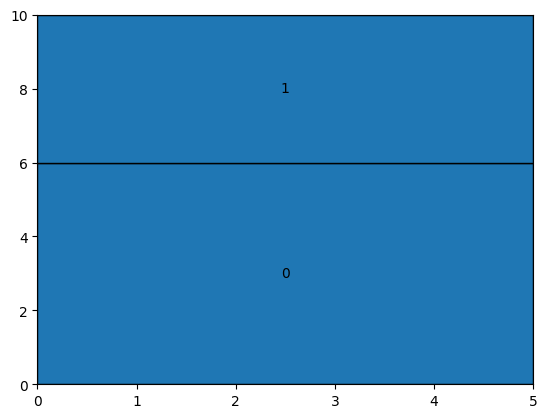

In [12]:
run(a,b,c,l,w,h,prices)

Simple Horizontal Stacking Example:

In [13]:
#Dimensions of BOM items:
a = np.array([10,10]) #longest dimension
b = np.array([2.5,2.5]) #mid dimension
c = np.array([0.5,0.5]) #smallest dimension

#Dimensions of UNIQUE stock items available for purchase:
l = np.array([10]) #longest dimension
w = np.array([5]) #mid dimension
h = np.array([0.5]) #smallest dimension

#Prices of UNIQUE stock items available for purchase:
prices = [30]

presolving:
(round 1, fast)       6 del vars, 14 del conss, 0 add conss, 4 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 6 clqs
(round 2, exhaustive) 6 del vars, 14 del conss, 0 add conss, 4 chg bounds, 0 chg sides, 0 chg coeffs, 4 upgd conss, 0 impls, 6 clqs
(round 3, exhaustive) 6 del vars, 14 del conss, 17 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 10 upgd conss, 0 impls, 6 clqs
(round 4, fast)       8 del vars, 16 del conss, 17 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 12 upgd conss, 0 impls, 48 clqs
(round 5, exhaustive) 10 del vars, 18 del conss, 19 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 12 upgd conss, 0 impls, 43 clqs
(round 6, fast)       10 del vars, 20 del conss, 19 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 12 upgd conss, 0 impls, 44 clqs
(round 7, exhaustive) 12 del vars, 22 del conss, 21 add conss, 6 chg bounds, 0 chg sides, 0 chg coeffs, 12 upgd conss, 0 impls, 38 clqs
(round 8, fast)       12 del vars, 24 del conss

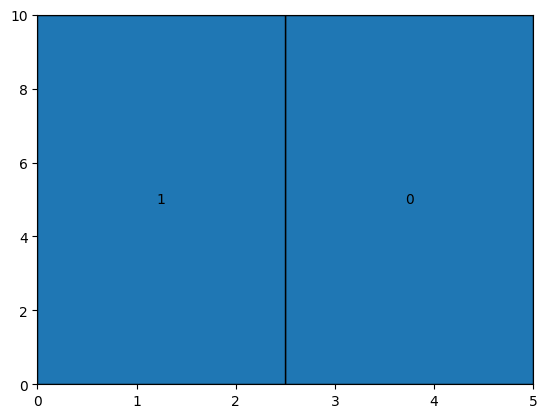

In [14]:
run(a,b,c,l,w,h,prices)

More complex "quadrant" example:

In [15]:
#Dimensions of BOM items:
a = np.array([5,5,9,10]) #longest dimension
b = np.array([4,5,5,5]) #mid dimension
c = np.array([0.5,0.5,0.5,0.5]) #smallest dimension

#Dimensions of UNIQUE stock items available for purchase:
l = np.array([15,15]) #longest dimension
w = np.array([10,15]) #mid dimension
h = np.array([0.5,0.5]) #smallest dimension

#Prices of UNIQUE stock items available for purchase:
prices = [30,40]

presolving:
(round 1, fast)       8 del vars, 72 del conss, 0 add conss, 8 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 28 clqs
(round 2, fast)       9 del vars, 72 del conss, 0 add conss, 8 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 28 clqs
(round 3, exhaustive) 9 del vars, 72 del conss, 0 add conss, 8 chg bounds, 0 chg sides, 0 chg coeffs, 28 upgd conss, 0 impls, 28 clqs
(round 4, exhaustive) 9 del vars, 72 del conss, 696 add conss, 8 chg bounds, 0 chg sides, 0 chg coeffs, 124 upgd conss, 0 impls, 28 clqs
(round 5, exhaustive) 9 del vars, 72 del conss, 696 add conss, 8 chg bounds, 0 chg sides, 0 chg coeffs, 188 upgd conss, 0 impls, 1956 clqs
   (1.0s) probing cycle finished: starting next cycle
   (1.0s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (1.0s) symmetry computation finished: 6 generators found (max: 1500, log10 of symmetry group size: 0.0) (symcode time: 0.00)
dynamic symmetry handling 

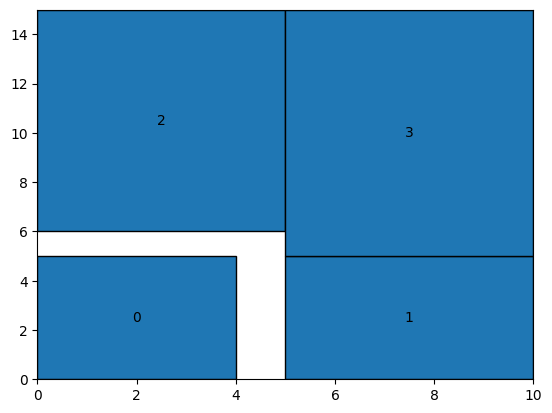

In [16]:
run(a,b,c,l,w,h,prices)

Most Complex Example with Long Skinny Board:

In [17]:
#Dimensions of BOM items:
a = np.array([5,5,10,9,10]) #longest dimension
b = np.array([4,5,1,5,5]) #mid dimension
c = np.array([0.5,0.5,0.5,0.5,0.5]) #smallest dimension

#Dimensions of UNIQUE stock items available for purchase:
l = np.array([15,15]) #longest dimension
w = np.array([10,15]) #mid dimension
h = np.array([0.5,0.5]) #smallest dimension

#Prices of UNIQUE stock items available for purchase:
prices = [30,40]

presolving:
(round 1, fast)       10 del vars, 110 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 45 clqs
(round 2, fast)       11 del vars, 110 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 45 clqs
(round 3, exhaustive) 11 del vars, 110 del conss, 0 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 45 upgd conss, 0 impls, 45 clqs
(round 4, exhaustive) 11 del vars, 110 del conss, 1460 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 195 upgd conss, 0 impls, 45 clqs
(round 5, exhaustive) 11 del vars, 110 del conss, 1460 add conss, 10 chg bounds, 0 chg sides, 0 chg coeffs, 295 upgd conss, 0 impls, 3574 clqs
   (2.0s) probing: 1000/1644 (60.8%) - 0 fixings, 0 aggregations, 563648 implications, 0 bound changes
   (2.0s) probing: 1001/1644 (60.9%) - 0 fixings, 0 aggregations, 564426 implications, 0 bound changes
   (2.0s) probing aborted: 1000/1000 successive useless probings
   (2.0s) symmetry compu

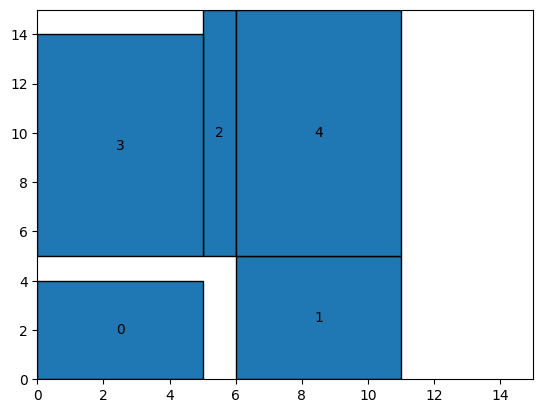

In [18]:
run(a,b,c,l,w,h,prices)